In [1]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

current version: 1.0.0beta8


# STEM simulation of MoS$_2$

We set up an atomic structure with ASE and make sure to repeat the structure to improve the Fourier space sampling for our diffraction patterns.

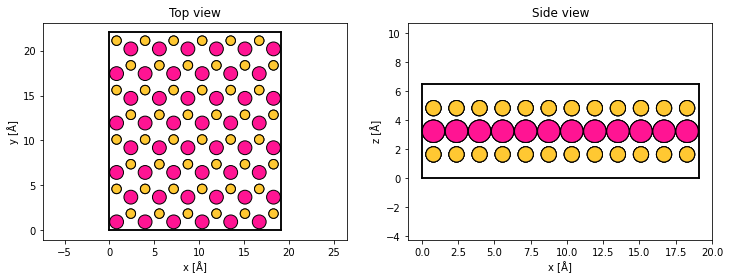

In [7]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)

repetitions = (6, 4, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.cell[2,2] = 6.5
atoms.center()

#atoms *= (1,1,5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [8]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([19.080000000000002, 22.03168627227612, 6.5])


We create and calculate the electrostatic potential.

In [21]:
from tqdm.auto import tqdm


potential = Potential(atoms, 
                      gpts=512,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

for i in tqdm(range(1000)):
    potential._integrators = {}
    p = potential.build(pbar=False)

#p.array.shape

#plt.imshow(p.array[16])

#p.project().show()

#potential = potential.build(pbar=False, max_batch=1)

#potential._integrators[42]._order#.estimate_step_size_and_order(1)

#potential.project().show(power=1)

KeyboardInterrupt: 

In [5]:
potential.sampling

(0.037265625000000004, 0.043030637250539294)

In [6]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.037265625000000004, 0.043030637250539294)


We create a probe with a semi-angle cutoff of 20 mrad.

In [7]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

In [19]:
probe = SMatrix(energy=80e3, semiangle_cutoff=20, expansion_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

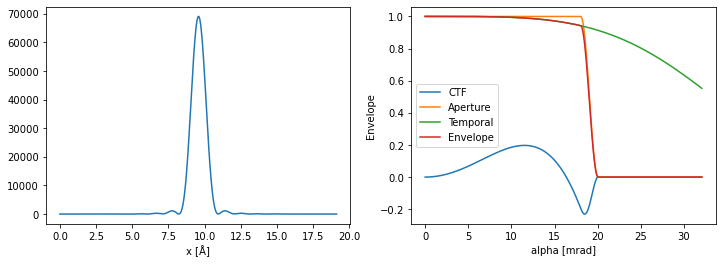

In [8]:

probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
probe.profile().show(ax=ax1);
probe.ctf.show(ax=ax2);

In [21]:
probe.cutoff_scattering_angles

(259.3408557096382, 259.2801792237621)

We create a `Pixelated` detector which will detect . We scan over one periodic unit of the potential at the nyquist frequency of the probe.

In [9]:
detector = FlexibleAnnularDetector()

In [14]:

end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurements = probe.scan(gridscan, [detector], potential)

In [11]:
measurements[detector].array.shape

(7, 12, 323)

In [12]:
integrated_measurement = measurements[detector].integrate(50, 150)

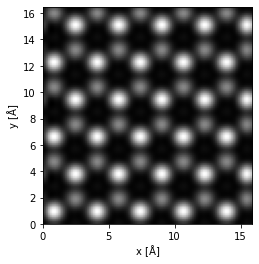

In [13]:
integrated_measurement.tile((5,3)).interpolate(.05).show();